# Ajusta modelo SEIR

In [33]:
import CSV
import DataFrames
import Dates
using Plots
using RollingFunctions
using Printf
pyplot()
include("la_dança.jl")

fit_initial (generic function with 1 method)

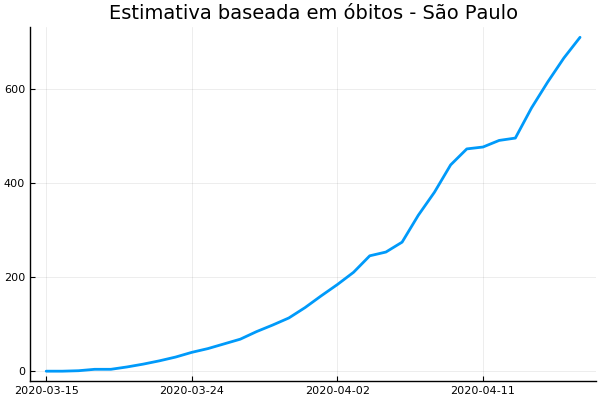

In [34]:
# Maximum allowed RT, using estimated values (the actual value should be around 2.5)
col = Dict("casos" => 4, "óbitos" => 6)
tipo = "casos"
max_rt = 10.0
tempo_para_curar = 14

# Read data

# Dados Brasil
#nome="Brasil"
#col = Dict("casos" => 2, "óbitos" => 4)
#data = DataFrames.DataFrame(CSV.File("BrasilCov19.csv"; missingstring="?"))
#populacao = 211388000 # população do Brasil

# Dados Estados
nome, sigla = "São Paulo", "SP"
data = DataFrames.DataFrame(CSV.File("EstadosCov19.csv"; missingstring="?"))
data = data[data.estado .== sigla, :]
populacoes = DataFrames.DataFrame(CSV.File("populacoes_estados.csv"))
populacao = populacoes[populacoes[:,1] .== nome, 7]

# Seleciona os dados com um mínimo de informação
primeiro = findfirst(x -> x > 0, data[:, col[tipo] + 1])
data = data[maximum( (1, primeiro - tempo_para_curar - 1) ):end, :]
novos_casos = map(x -> x === missing ? 0.0 : x, data[:, col[tipo]])
infectados = rolling(sum, novos_casos, tempo_para_curar)

dia_quarentena = Dates.Date(2020, 03, 24)
inicio_quarentena = (dia_quarentena - data.data[1]).value - tempo_para_curar

plot(data.data[tempo_para_curar:end], infectados, lw=2, legend=:topleft, label="")
title!("Estimativa baseada em $tipo - $nome")

In [35]:
# Cria modelo SEIR e ajusta paramêtros tentando achar a evolução do rt
ndias = length(infectados)
iparam = SEIR_Parameters(ndias, 0, 0, 0, 0)
m = seir_model_with_free_initial_values(iparam)
lastday = iparam.ndays - 1

# Define estado inicial
s0, e0, i, r0, rt = m[:s][0], m[:e][0], m[:i], m[:r][0], m[:rt]
fix(r0, iparam.r0; force=true)
set_start_value(s0, iparam.s0)
set_start_value(e0, iparam.e0)
set_start_value(i[0], iparam.i0)

# Ajusta o limitante superior dos rts para um valor alto pré-determinando nesse arquivo.
for d = 0:lastday
    set_upper_bound(rt[d], max_rt)
end

#janelas = [0, inicio_quarentena + 5]
janelas = 0:7:lastday
taxa_max = 1000
for j = 1:length(janelas)
    inicio_jan = janelas[j]
    fim_jan = j < length(janelas) ? janelas[j + 1] - 1 : lastday
    if inicio_jan > 0
        @constraint(m, rt[inicio_jan] <= taxa_max*rt[janelas[j - 1]])
        @constraint(m, rt[inicio_jan] >= 1.0/taxa_max*rt[janelas[j - 1]])
    end
    for d = inicio_jan + 1:fim_jan
        @constraint(m, rt[d] == rt[inicio_jan])
    end
end
@constraint(m, rt[lastday] == rt[lastday - 1])

# Restrição para calular a variação total
@variable(m, ttv[1:lastday])
@constraint(m, con_ttv[i=1:lastday], ttv[i] >= rt[i - 1] - rt[i])
@constraint(m, con_ttv2[i=1:lastday], ttv[i] >= rt[i] - rt[i - 1])

# As proporções somam 1
@constraint(m, s0 + e0 + i[0] + r0 == 1.0)

# Compute a scaling factor so as a least square objetive makes more sense
infectados /= populacao
factor = 1.0/mean(infectados)
erro2_i = sum((factor*(i[t] - infectados[t + 1]))^2 for t = 0:lastday)
@objective(m, Min, sum((factor*(i[t] - infectados[t + 1]))^2 for t = 0:lastday) + 0.5*sum(ttv))
optimize!(m)

Total number of variables............................:      202
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      169
                     variables with only upper bounds:        0
Total number of equality constraints.................:      163
Total number of inequality constraints...............:       74
        inequality constraints with only lower bounds:       70
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        4


Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   4.4810428301699967e-05    5.7125673400571486e-01
Dual infeasibility......:   2.4954127675803791e-10    3.1812267849938169e-06
Constraint violation....:   2.0870811299938156e-13    2.0870811299938156e-13
Complementarity.........:   2.5075542780004246e-09    3.1967051453918770e-05
Overall NLP e

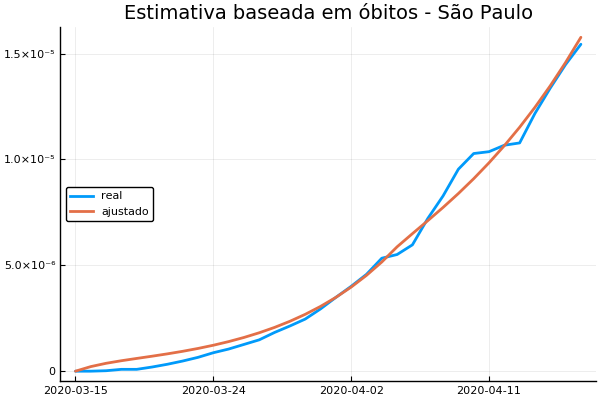

In [36]:
# Mostra a previsão do modelo SEIR com parâmetros ajustados e dados reais para comparação
ajustado = value.(m[:i]).data
plot(data.data[tempo_para_curar:end], infectados, lw=2, legend=:left, label="real")
plot!(data.data[tempo_para_curar:end], ajustado, lw=2, label="ajustado")
title!("Estimativa baseada em $tipo - $nome")

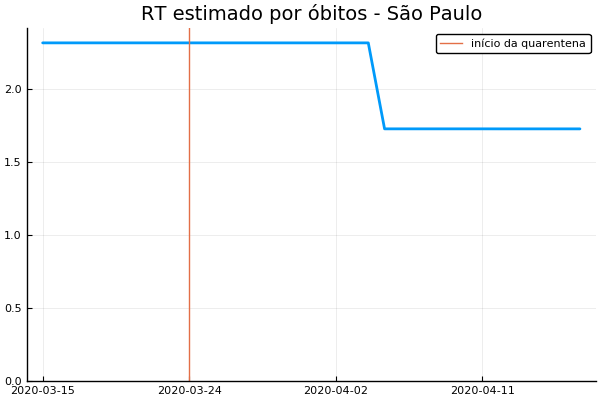

In [37]:
# Apresenta o RT estimado, note que ele cai :-)
rt_est = copy(value.(m[:rt]).data)
plot(data.data[tempo_para_curar:end], rt_est, lw=2, label="")
ylims!(0.0, maximum(rt_est) + 0.1)
vline!([dia_quarentena], label="início da quarentena")
title!("RT estimado por $tipo - $nome")

In [38]:
janela = 7
r0_inicial = mean(rt_est[maximum((inicio_quarentena - janela + 1, 1)):inicio_quarentena])
r0_final = mean(rt_est[end - janela + 1:end])
print("R0 inicial = $r0_inicial, final = $r0_final")

R0 inicial = 2.318062463907732, final = 1.7288510538907773

Total number of variables............................:      801
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      801
                     variables with only upper bounds:        0
Total number of equality constraints.................:      800
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 38

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   7.3047684937484788e-14    7.3047684937484788e-14
Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
Complementarity.........:   2.5059035596904466e-09    2.5059035596904466e-09
Overall NLP e

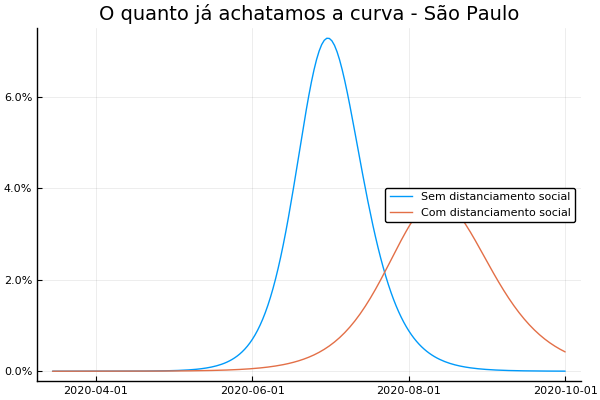

In [39]:
# Agora calcula como seria a infeccão somente com a taxa inicial e depois com a 
# nova taxa
inicio = data.data[tempo_para_curar]
# fim = inicio + 364*Dates.Day(1)
fim = Dates.Date(2020, 10, 01)
datas = inicio:Dates.Day(1):fim
iparam = SEIR_Parameters(length(datas), value(m[:s][0]), value(m[:e][0]), value(m[:i][0]), value(m[:r][0]))
lastday = iparam.ndays - 1
m = seir_model(iparam)
rt = m[:rt]

# Fix all rts
n_est = length(rt_est)
for d = 1:n_est - 7
    fix(rt[d], rt_est[d]; force=true)
end
for d = n_est - 6:lastday
    fix(rt[d], r0_inicial; force=true)
end
optimize!(m)
i_antes = copy(value.(m[:i]).data)
r_antes = copy(value.(m[:r]).data)
plot(datas, i_antes, legend=:right, label="Sem distanciamento social", yformatter=x->@sprintf("%.1f%%", 100*x))

m = seir_model(iparam)
rt = m[:rt]

# Fix all rts
for d = 1:n_est - 7
    fix(rt[d], rt_est[d]; force=true)
end
for d = n_est - 6:lastday
    fix(rt[d], r0_final; force=true)
end
            
optimize!(m)
i_depois = copy(value.(m[:i]).data)
r_depois = copy(value.(m[:r]).data)
plot!(datas, i_depois, label="Com distanciamento social", yformatter=x->@sprintf("%.1f%%", 100*x))
title!("O quanto já achatamos a curva - $nome")

In [40]:
# Estima vidas "salvas"
taxa_letalidade = 0.02
n_dias = 14
hoje = Dates.Date(2020, 04, 17)
ind_hoje = (hoje - inicio).value
r_antes = r_antes[ind_hoje:ind_hoje + n_dias + 1]
r_depois = r_depois[ind_hoje:ind_hoje + n_dias + 1]
obitos_antes = (taxa_letalidade * populacao) .* (r_antes[2:end] .- r_antes[1:end - 1])
obitos_depois = (taxa_letalidade * populacao) .* (r_depois[2:end] .- r_depois[1:end - 1])
salvas = Int.(round.(obitos_antes - obitos_depois))
println("Vidas salvas nos próximos $n_dias = $salvas")
println("Estimativa de óbitos = ", obitos_antes)

Vidas salvas nos próximos 14 = [1, 2, 2, 3, 3, 4, 5, 7, 8, 10, 12, 14, 16, 20, 23]
Estimativa de óbitos = [6.187112026074637, 7.04416611673677, 8.023028292811317, 9.139611474685523, 10.412512484003376, 11.863176228266616, 13.516175329667485, 15.399579860837044, 17.545406673926543, 19.99014651095779, 22.77537244551596, 25.948436779705542, 29.563266173438702, 33.68126700393187, 38.37235501954142]
